# Simulate some data to test the method. branch = gyro_switch

In [49]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from tqdm import tqdm

import read_mist_models
from isochrones.mist import MIST_Isochrone
from isochrones.dartmouth import Dartmouth_Isochrone
from isochrones import StarModel

from stardate.lhf import gyro_model_rossby, gyro_model

mist = MIST_Isochrone()
dart = Dartmouth_Isochrone()

In [50]:
plotpar = {'axes.labelsize': 25,
           'font.size': 25,
           'legend.fontsize': 25,
           'xtick.labelsize': 25,
           'ytick.labelsize': 25,
           'text.usetex': True}
plt.rcParams.update(plotpar)

Draw randomly from mass, age, metallicity, distance and extinction distributions.

In [51]:
np.random.seed(42)
# N = 1000
# eep, eep_err = np.random.uniform(195, 480, size=N), np.ones(N)*10
# age = np.log10(np.random.uniform(.5, 14, size=N)*1e9)
# age_err = age*.2
# feh, feh_err = np.random.uniform(-.2, .2, size=N), np.ones(N)*.01
# mass = mist.mass(eep, age, feh)
# d_kpc = np.random.uniform(.01, 1, size=N)
# dkpc_err = d_kpc*.1
# d_pc = d_kpc*1e3
# dpc_err = d_pc*.1
# av, av_err = np.random.uniform(0, 1, size=N), np.ones(N)*.01

N = 1000
eep, eep_err = np.random.uniform(250, 320, size=N), np.ones(N)*10
age = np.log10(np.random.uniform(1, 3, size=N)*1e9)
age_err = age*.2
feh, feh_err = np.random.uniform(-.01, .01, size=N), np.ones(N)*.01
mass = mist.mass(eep, age, feh)
d_kpc = np.random.uniform(.01, 1, size=N)
dkpc_err = d_kpc*.1
d_pc = d_kpc*1e3
dpc_err = d_pc*.1
av, av_err = np.random.uniform(0, .1, size=N), np.ones(N)*.01

# Save as a pandas data frame
df = pd.DataFrame(dict({"eep": eep, "eep_err": eep_err,
                        "age": age, "age_err": age_err,
                        "feh": feh, "feh_err": feh_err,
                        "d_kpc": d_kpc, "dkpc_err": dkpc_err,
                        "Av": av, "Av_err": av_err}))

Use isochrones model to predict $T_\mathrm{eff}$, observed metallicity, $\hat{F}$, apparent magnitudes $J$, $H$, $K$, $B$, $V$, $\log(g)$ and parallax. Use Gyrochronology model to predict rotation period from age and $B$-$V$ color.

In [52]:
logg, teff, B, V, J, H, K, logL = [np.zeros(N) for i in range(8)]
for i in range(N):
    logg[i] = mist.logg(eep[i], age[i], feh[i])
    teff[i] = mist.Teff(eep[i], age[i], feh[i])
    B[i] = mist.mag["B"](eep[i], age[i], feh[i], d_pc[i], av[i])  # parsecs, not kpc!!!
    V[i] = mist.mag["V"](eep[i], age[i], feh[i], d_pc[i], av[i])  # parsecs, not kpc!!!
    J[i] = mist.mag["J"](eep[i], age[i], feh[i], d_pc[i], av[i])  # parsecs, not kpc!!!
    H[i] = mist.mag["H"](eep[i], age[i], feh[i], d_pc[i], av[i])  # parsecs, not kpc!!!
    K[i] = mist.mag["K"](eep[i], age[i], feh[i], d_pc[i], av[i])  # parsecs, not kpc!!!
    logL[i] = mist.logL(eep[i], age[i], feh[i])
    
df["BV"], df["B"], df["V"], df["jmag"], df["hmag"], df["kmag"] = B - V, B, V, J, H, K
df["logg"], df["teff"], df["logL"], df["parallax"] = logg, teff, logL, 1./d_kpc
df["mass"] = mist.mass(df.eep, df.age, df.feh)

Plot the simulated data on an HR diagram.

Text(0,0.5,'$\\log(g)$')

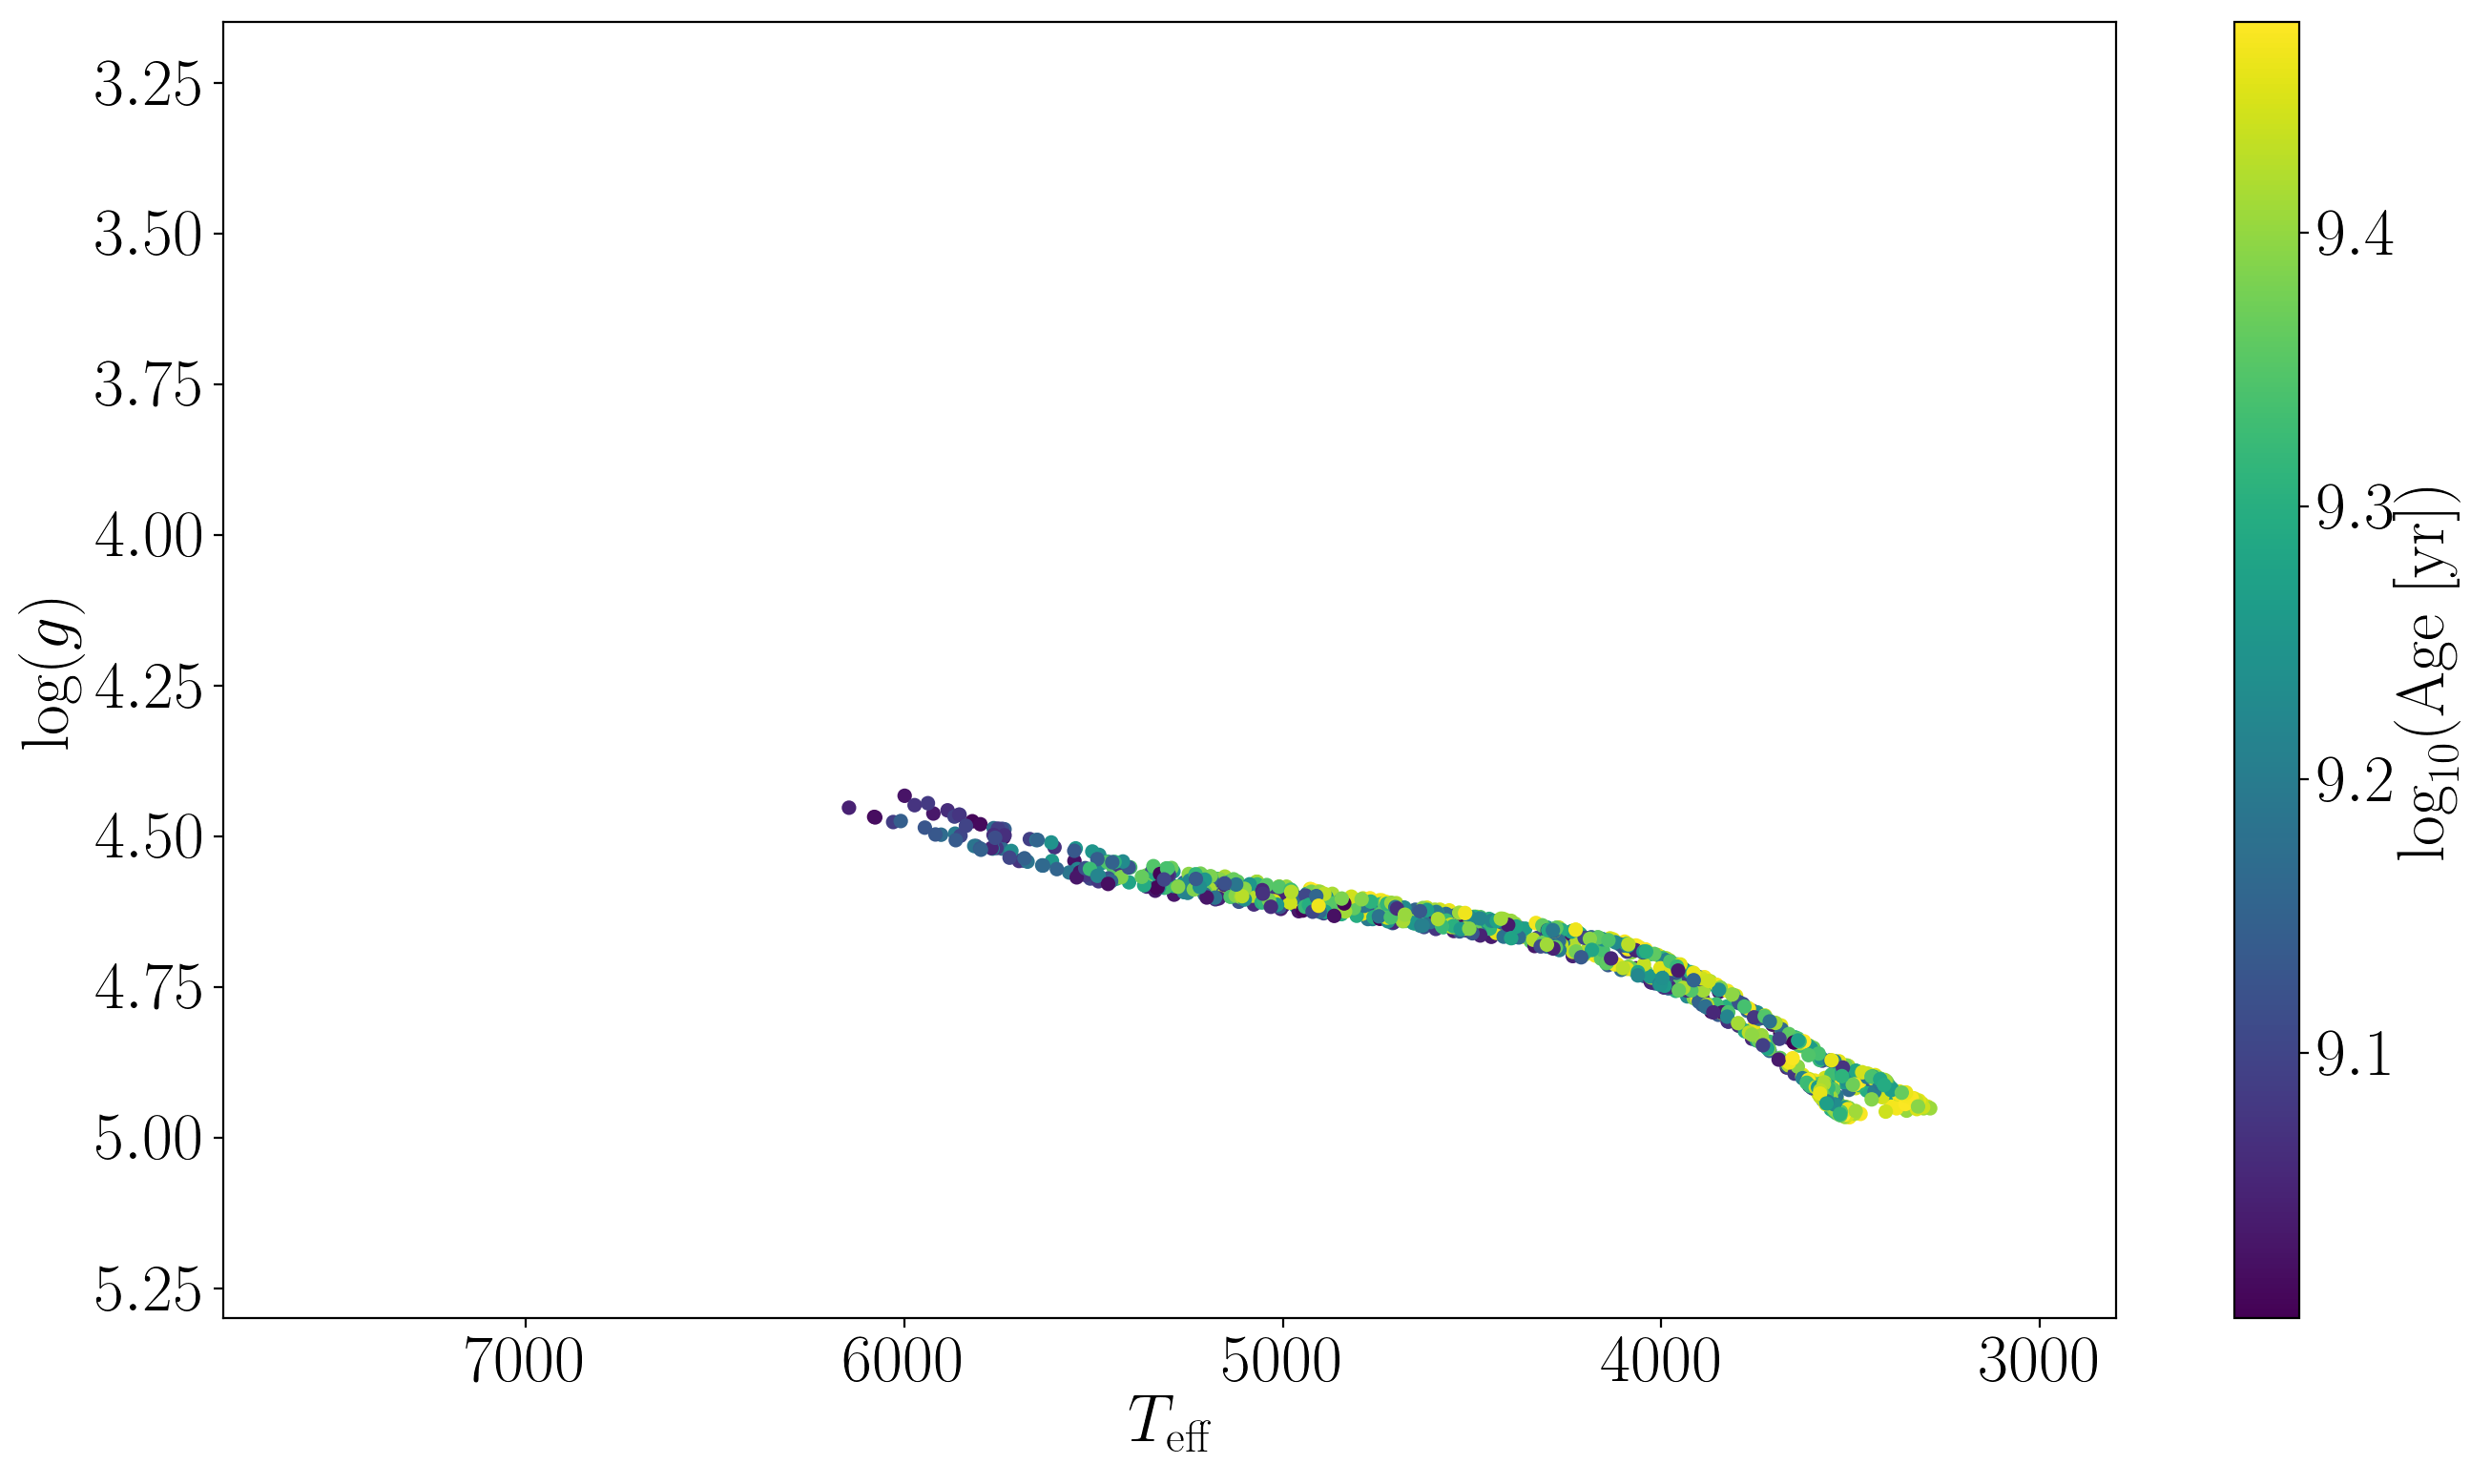

In [53]:
plt.figure(figsize=(16, 9), dpi=200)
plt.scatter(teff, logg, c=age, s=20)
plt.colorbar(label="$\log_{10}(\mathrm{Age~[yr]})$")
plt.xlim(7800, 2800)
plt.ylim(5.3, 3.15)
plt.xlabel("$T_{\mathrm{eff}}$")
plt.ylabel("$\log(g)$")

Now calculate the rotation periods of these stars from their ages and B-V colours.

In [54]:
def gyro_rot(log_age_yr, bv):
    age_myr = (10**(log_age_yr))*1e-6
    a, b, c, n = [.4, .31, .45, .55]
    return age_myr**n * a * (bv - c)**b

def gyro_age(period, bv):
    a, b, c, n = [.4, .31, .45, .55]
    return np.log10(((period/(a*(bv-c)**b))**(1./n))*1e6)

# def convective_overturn_time(*args):
#     """
#     Estimate the convective overturn time using equation 11 in Wright et al.
#     (2011): https://arxiv.org/abs/1109.4634
#     log tau = 1.16 - 1.49log(M/M⊙) - 0.54log^2(M/M⊙)
#     (I assume log is log10)
#     params:
#     ------
#     EITHER:
#     mass: (float)
#         Mass in Solar units
#     OR
#     eep: (float)
#         The Equivalent evolutionary point of a star. 355 for the Sun.
#     age: (float)
#         The age of a star in log_10(years).
#     feh: (float)
#         The metallicity of a star.
#     """

#     if len(args) > 1:
#         # Convert eep, age and feh to mass (mass will be in Solar mass units)
#         eep, age, feh = args
#         M = mist.mass(eep, age, feh)
#     else:
#         M = args[0]

#     log_tau = 1.16 - 1.49*np.log10(M) - .54*(np.log10(M))**2
#     return 10**log_tau


# def gyro_model_rossby(log10_age, bv, mass, rossby=True, Ro_cutoff=2.16):
#     """
#     Predict a rotation period from an age and color (and mass if the rossby
#     cutoff model is used).
#     params:
#     -------
#     args: (list)
#         Either containing [log10_age, bv] in which case the standard gyro
#         model will be used.
#         Or [mass, log10_age, bv] in which case the Rossby number cutoff model
#         will be used.
#     Ro_cutoff: (float, optional)
#         The critical Rossby number after which stars retain their rotation
#         period.
#         This is 2.16 in van Saders et al. (2016) and 2.08 in van Saders et al.
#         (2018).
#     """
#     # Angus et al. (2015) parameters.
#     a, b, c, n = [.4, .31, .45, .55]

#     age_myr = (10**log10_age)*1e-6

#     if not rossby:  # If Rossby model is switched off
#         # Standard gyro model
#         log_P = n*np.log10(age_myr) + np.log10(a) + b*np.log10(bv-c)
#         return 10**log_P

#     # Otherwise the Rossby model is switched on.
#     # Calculate the maximum theoretical rotation period for this mass.
#     pmax = Ro_cutoff * convective_overturn_time(mass)

#     # Calculate the age this star reaches pmax, based on its B-V color.
#     age_thresh_myr = (pmax/(a*(bv-c)**b))**(1./n)
#     log10_age_thresh = np.log10(age_thresh_myr*1e6)

#     # If star younger than critical age, predict rotation from age and color.
#     if log10_age < log10_age_thresh:
#         log_P = n*np.log10(age_myr) + np.log10(a) + b*np.log10(bv-c)

#     # If star older than this age, return maximum possible rotation period.
#     else:
#         log_P = np.log10(pmax)
#     return 10**log_P

Calculate periods for these stars.

In [55]:
# Calculate periods. NaNs will appear for stars with B-V < 0.45
prot = np.empty(N)
for i in range(N):
    prot[i] = gyro_model_rossby(df.age.values[i], df.BV.values[i], 
                                df.mass.values[i], rossby=False)
#     prot[i] = gyro_model(df.age.values[i], df.BV.values[i])
    
# # random periods for cool stars.
# cool_mask = df.BV > 1.6
# prot[cool_mask] = 10**np.random.uniform(-.7, 1.5, len(prot[cool_mask]))

# # Random periods for hot stars.
# hot_mask = .45 > df.BV
# # prot[hot_mask] = abs(np.random.randn(len(prot[hot_mask]))*20. + 5)
# prot[hot_mask] = 10**(np.random.randn(len(prot[hot_mask]))*.55 + .5)

# # Give the evolved stars randomly distributed rotation periods
# evolved_mask = df.eep > 454
# # prot[evolved_mask] = abs(np.random.randn(len(prot[evolved_mask]))*20. + 5)
# prot[evolved_mask] = 10**(np.random.randn(len(prot[evolved_mask]))*.55 + .5)

df["prot"] = prot

# Cut unphysical masses
finite_mask = np.isfinite(df.mass.values)
finite_df = df.iloc[finite_mask]
print(len(df.mass.values), "stars originally, ", len(df.mass.values[finite_mask]), "after cuts")

1000 stars originally,  1000 after cuts


Text(0,0.5,'$\\mathrm{Rotation~period~[days]}$')

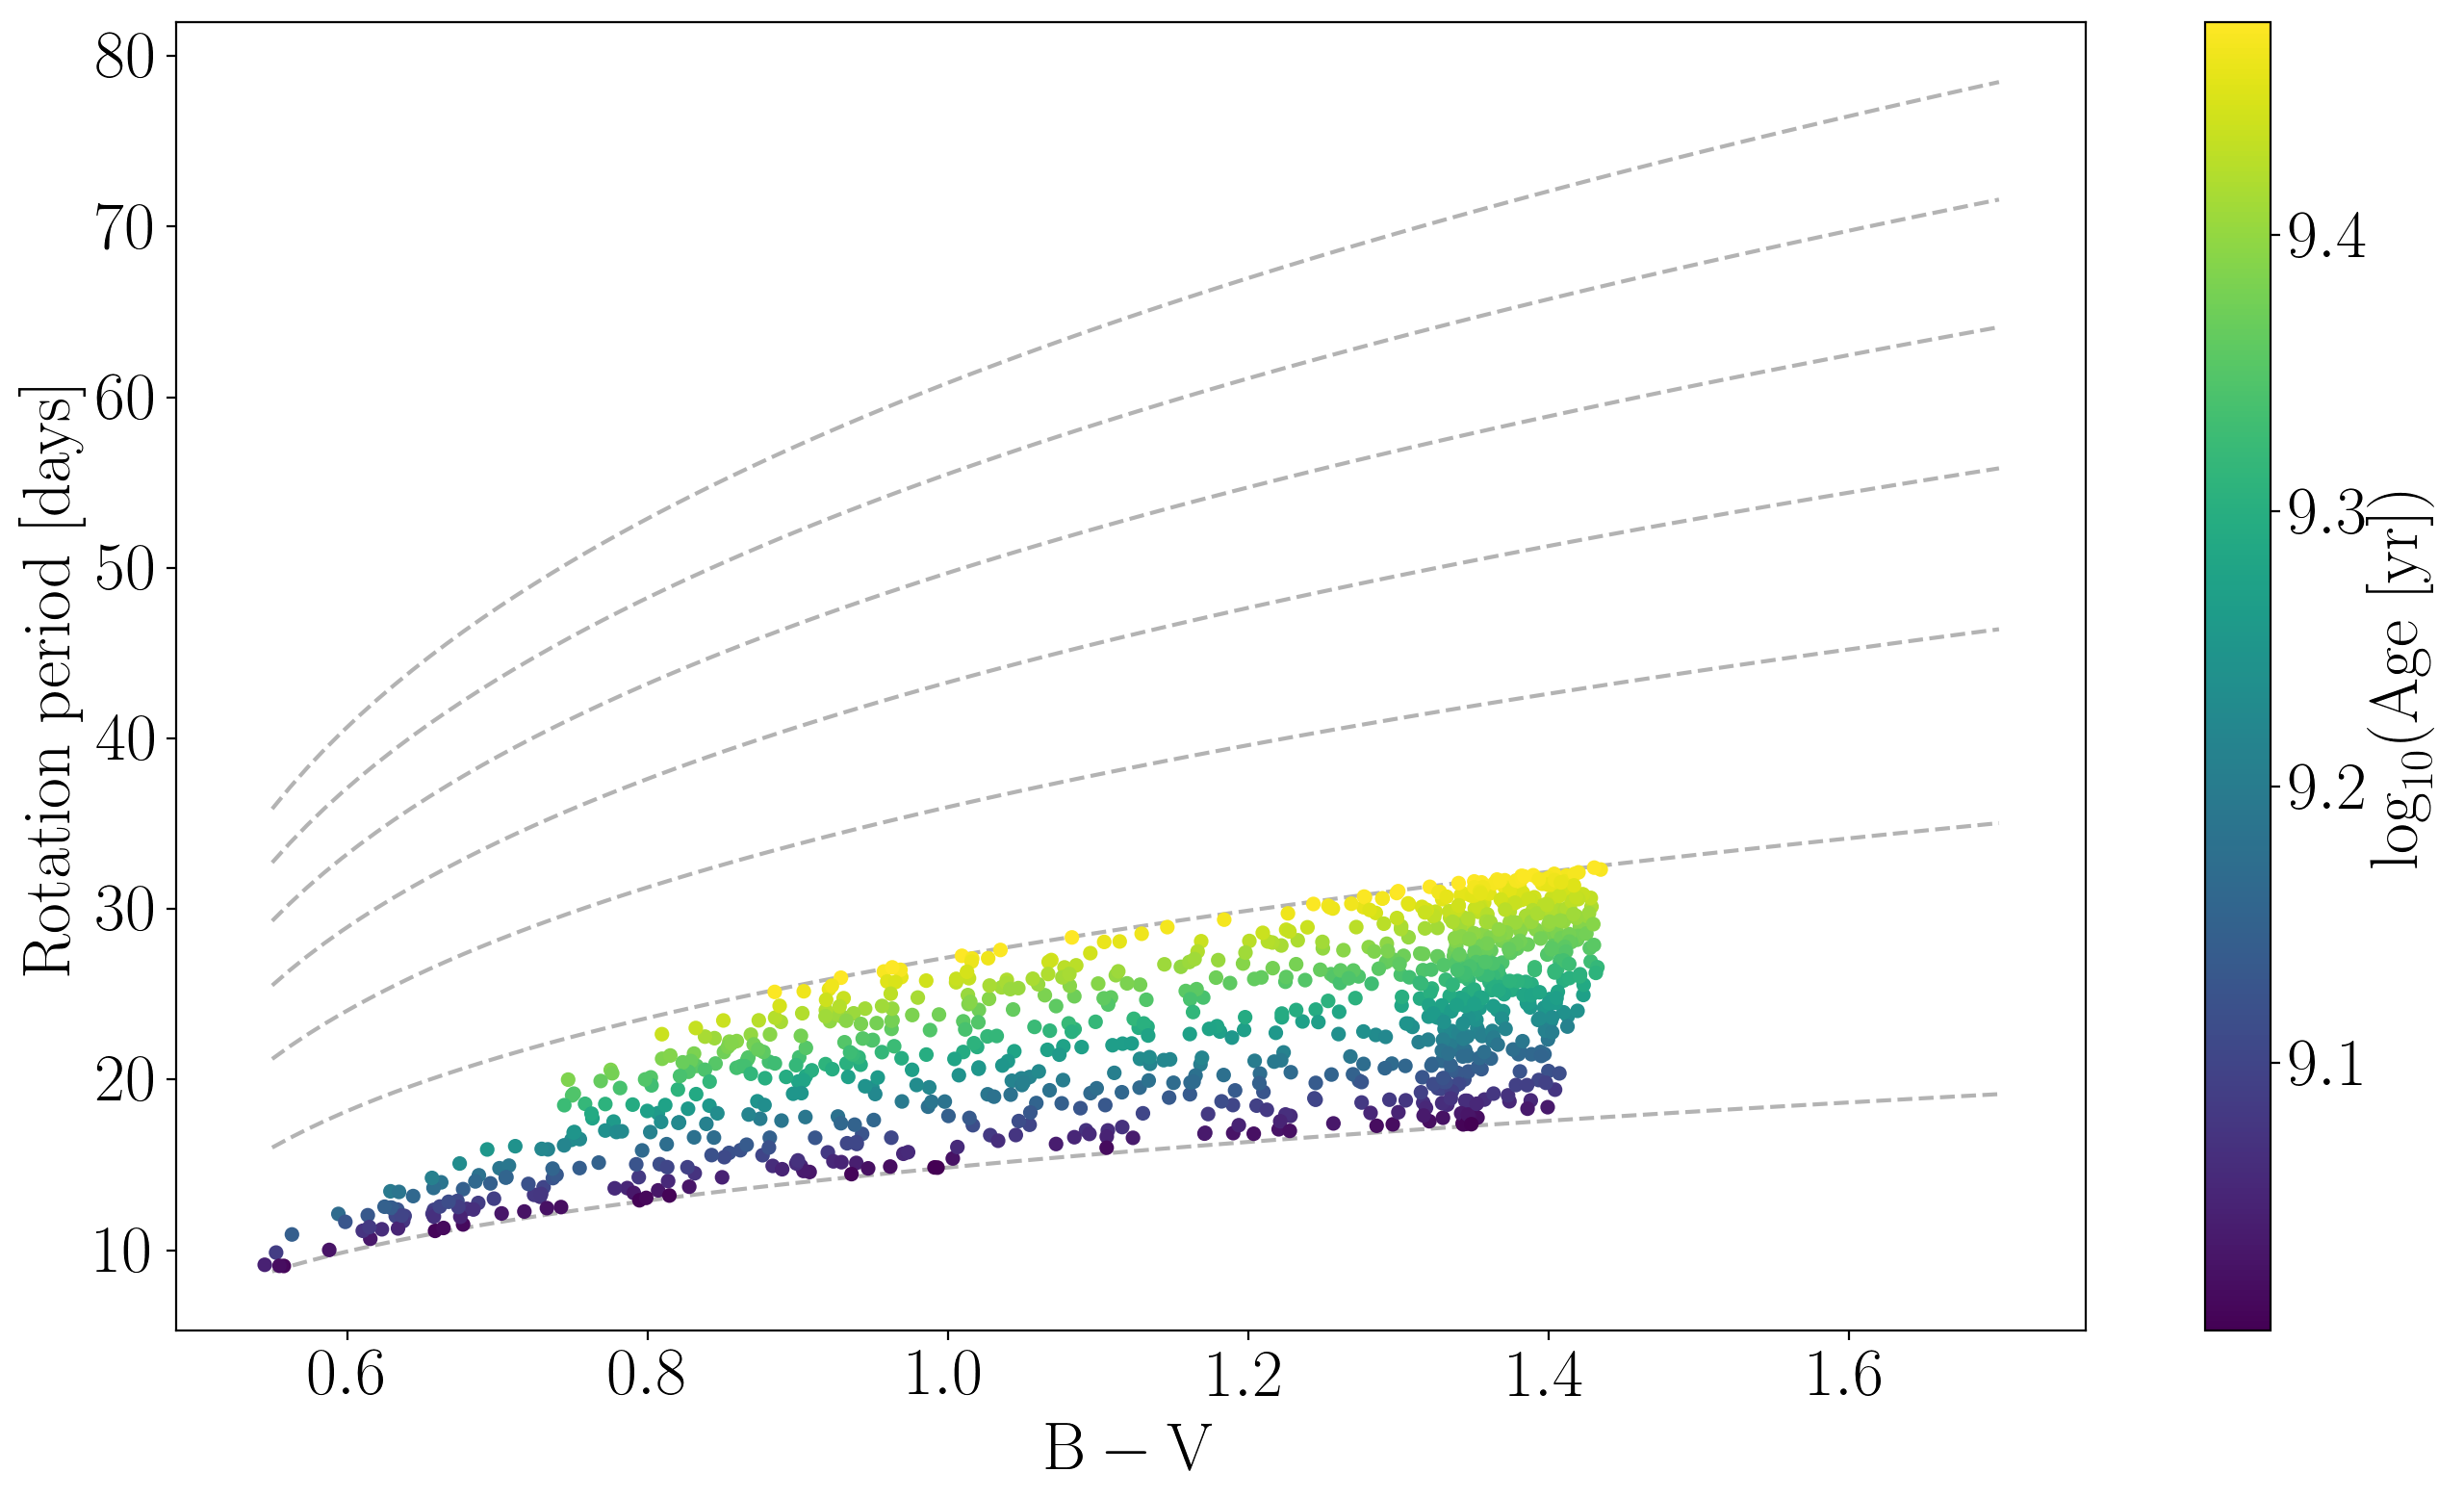

In [56]:
plt.figure(figsize=(16, 9), dpi=200)

# Plot models
xs = np.linspace(.55, 1.7, 100)
for a in range(1, 14, 2):
    plt.plot(xs, gyro_rot(np.log10(a*1e9), xs), color=".7", ls="--", zorder=0)

plt.scatter(finite_df.BV, finite_df.prot, c=finite_df.age, s=20, zorder=1)
plt.colorbar(label="$\log_{10}(\mathrm{Age~[yr]})$")
plt.xlabel("$\mathrm{B-V}$")
plt.ylabel("$\mathrm{Rotation~period~[days]}$")

In [38]:
# plt.figure(figsize=(16, 9))

# # m = (df.age.values > np.log10(1.5*1e9)) * (np.log10(2.5*1e9) > df.age.values)
# # plt.loglog(df.BV[m], df.prot[m], ".", ms=20)

# m = (df.age.values > np.log10(3.9*1e9)) * (np.log10(4.1*1e9) > df.age.values)
# plt.loglog(df.BV[m], df.prot[m], ".", ms=20)

# # m = (df.age.values > np.log10(5.5*1e9)) * (np.log10(6.5*1e9) > df.age.values)
# # plt.loglog(df.BV[m], df.prot[m], ".", ms=20)

# m = (df.age.values > np.log10(7.9*1e9)) * (np.log10(8.1*1e9) > df.age.values)
# plt.loglog(df.BV[m], df.prot[m], ".", ms=20)

# # m = (df.age.values > np.log10(9.5*1e9)) * (np.log10(10.5*1e9) > df.age.values)
# # plt.loglog(df.BV[m], df.prot[m], ".", ms=20)

# m = (df.age.values > np.log10(11.9*1e9)) * (np.log10(12.1*1e9) > df.age.values)
# plt.loglog(df.BV[m], df.prot[m], ".", ms=20)

# # plt.loglog(bv_plot, period_plot[2, :])
# plt.loglog(bv_plot, period_plot[4, :], color="tab:blue")
# # plt.loglog(bv_plot, period_plot[6, :])
# plt.loglog(bv_plot, period_plot[8, :], color="tab:orange")
# # plt.loglog(bv_plot, period_plot[10, :])
# plt.loglog(bv_plot, period_plot[12, :], color="tab:green")

# plt.xlim(.4, 2.1)
# plt.ylim(5, 80)

/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log10
/Users/ruthangus/anaconda/lib/python3.5/site-packages/stardate_code-0.0.1-py3.5.egg/stardate/lhf.py:99: RuntimeWarning: divide by zero encountered in double_scalars
  age_thresh_myr = (pmax/(a*(bv-c)**b))**(1./n)
/Users/ruthangus/anaconda/lib/python3.5/site-packages/stardate_code-0.0.1-py3.5.egg/stardate/lhf.py:104: RuntimeWarning: divide by zero encountered in log10
  log_P = n*np.log10(age_myr) + np.log10(a) + b*np.log10(bv-c)


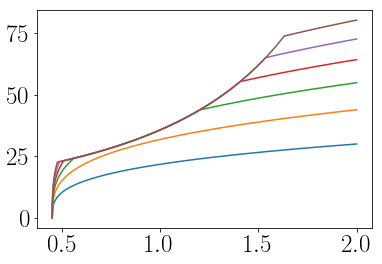

In [39]:
bv_plot = np.linspace(.45, 2., 1000)
mass_plot = np.linspace(1.25, .3, 1000)
period_plot = np.empty((14, 1000))

for j in range(14):
    for i in range(1000):
        period_plot[j, i] = gyro_model_rossby(np.log10(j*1e9), bv_plot[i], mass_plot[i])
plt.plot(bv_plot, period_plot[2, :])
plt.plot(bv_plot, period_plot[4, :])
plt.plot(bv_plot, period_plot[6, :])
plt.plot(bv_plot, period_plot[8, :])
plt.plot(bv_plot, period_plot[10, :])
plt.plot(bv_plot, period_plot[12, :])

Text(0,0.5,'$\\mathrm{Rotation~period~[days]}$')

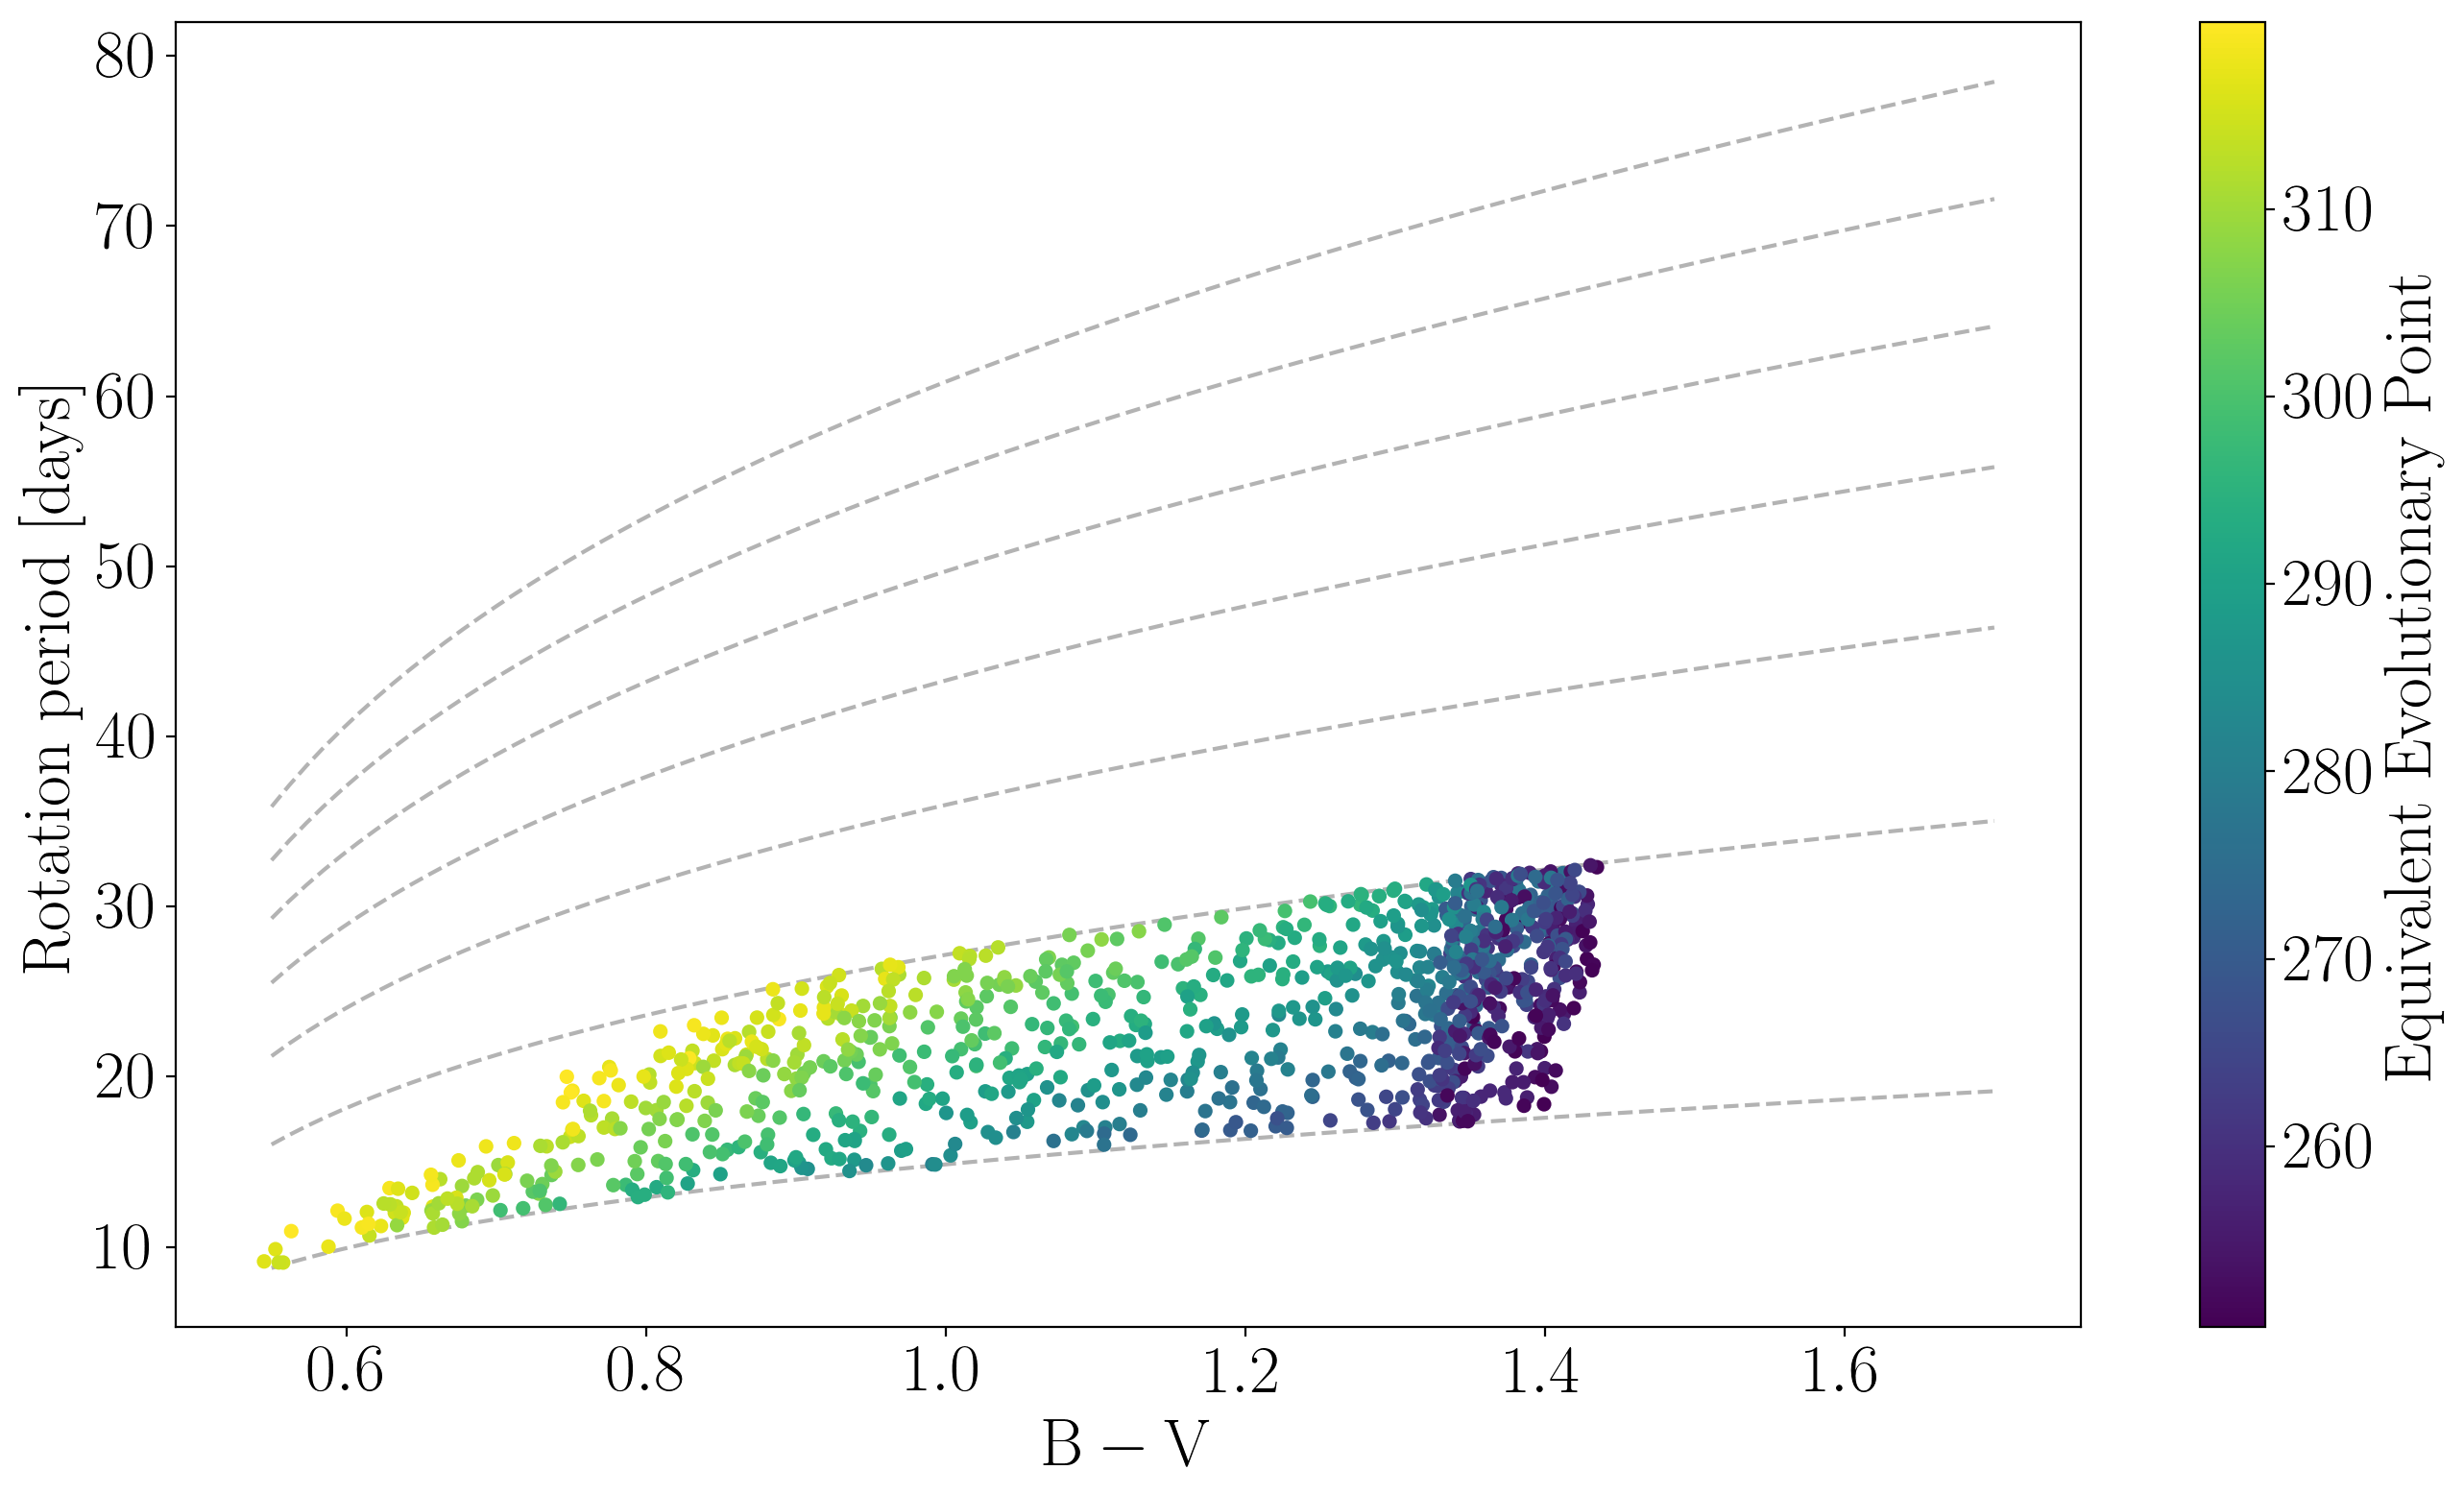

In [57]:
plt.figure(figsize=(16, 9), dpi=200)

# Plot models
xs = np.linspace(.55, 1.7, 100)
for a in range(1, 14, 2):
    plt.plot(xs, gyro_rot(np.log10(a*1e9), xs), color=".7", ls="--", zorder=0)

plt.scatter(finite_df.BV, finite_df.prot, c=finite_df.eep, s=20, zorder=1)
plt.colorbar(label="$\mathrm{Equivalent~Evolutionary~Point}$")
plt.xlabel("$\mathrm{B-V}$")
plt.ylabel("$\mathrm{Rotation~period~[days]}$")

Save simulated data file.

In [58]:
finite_df.to_csv("data/simulated_data.csv")

Text(0.5,0,'$\\mathrm{Mass~}[M_\\odot]$')

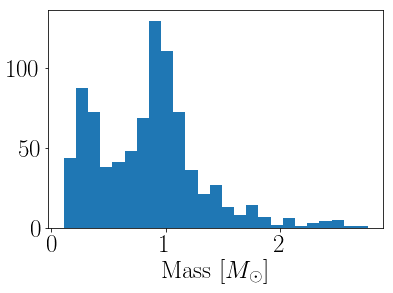

In [167]:
plt.hist(finite_df.mass, 25);
plt.xlabel("$\mathrm{Mass~}[M_\odot]$")